**Brian Blaylock**  
**April 4, 2019**

# Explore Contingency Table and Fractions Skill Score
## Hovemoller Diagram

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = [15,15]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.15
mpl.rcParams['figure.subplot.hspace'] = 0.15
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

SAVEDIR = '/uufs/chpc.utah.edu/common/home/u0553130/public_html/PhD/HRRR_GOES/GLM_hit_rate/'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio, \
                                                 gilbert_skill_score, \
                                                 proportion_correct, \
                                                 critical_success_index
from BB_HRRR.HRRR_paths import get_domains
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

Create HRRR map.
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.
dict_keys(['HRRR', 'West', 'Central', 'East', 'Utah', 'Colorado', 'Texas', 'Florida'])


In [2]:
domains = get_domains(add_states=['UT', 'CO', 'TX', 'FL'])

In [3]:
DOMAIN = 'HRRR'
month = 6
hour = 0
DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, month, hour)

data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')

In [4]:
print(data.dtype.names)

('DATE', 'GLM_Event_COUNT', 'NUM_FILES', 'EXPECTED_FILES', 'F01_A', 'F02_A', 'F03_A', 'F04_A', 'F05_A', 'F06_A', 'F07_A', 'F08_A', 'F09_A', 'F10_A', 'F11_A', 'F12_A', 'F13_A', 'F14_A', 'F15_A', 'F16_A', 'F17_A', 'F18_A', 'F01_B', 'F02_B', 'F03_B', 'F04_B', 'F05_B', 'F06_B', 'F07_B', 'F08_B', 'F09_B', 'F10_B', 'F11_B', 'F12_B', 'F13_B', 'F14_B', 'F15_B', 'F16_B', 'F17_B', 'F18_B', 'F01_C', 'F02_C', 'F03_C', 'F04_C', 'F05_C', 'F06_C', 'F07_C', 'F08_C', 'F09_C', 'F10_C', 'F11_C', 'F12_C', 'F13_C', 'F14_C', 'F15_C', 'F16_C', 'F17_C', 'F18_C', 'F01_D', 'F02_D', 'F03_D', 'F04_D', 'F05_D', 'F06_D', 'F07_D', 'F08_D', 'F09_D', 'F10_D', 'F11_D', 'F12_D', 'F13_D', 'F14_D', 'F15_D', 'F16_D', 'F17_D', 'F18_D')


In [5]:
DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
FILE = '/%s/%s_2018_m%02d_h%02d.csv' % ('HRRR', "HRRR", 7, 23)
data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')

In [6]:
def get_HRRR_GLM_stats_hov_by_month(DOMAIN, month):
    samples = []
    for hour in range(24):
        DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
        FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, month, hour)
        
        mean_HR = []
        mean_FAR = []
        mean_GSS = []
        mean_CSS = []
        mean_A = []
        mean_B = []
        mean_C = []
        mean_D = []
        sample_sum = []
        if os.path.exists(DIR+FILE):
            data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
            try:
                samples.append(len(data['DATE']))
            except:
                samples.append(1)
            #print(data['DATE'])
            
            for f in range(1,19):
                A = data['F%02d_A' % f]
                B = data['F%02d_B' % f]
                C = data['F%02d_C' % f]
                D = data['F%02d_D' % f]
                #events = data['GLM_Event_Count']

                mean_HR.append(np.nanmean(hit_rate(A, B, C, D)))
                mean_FAR.append(np.nanmean(false_alarm_ratio(A, B, C, D)))
                mean_GSS.append(np.nanmean(gilbert_skill_score(A, B, C, D)))
                mean_CSS.append(np.nanmean(critical_success_index(A, B, C, D)))
                mean_A.append(np.nanmean(A))
                mean_B.append(np.nanmean(B))
                mean_C.append(np.nanmean(C))
                mean_D.append(np.nanmean(D))

            if hour == 0:
                mean_HR_HOV = np.array(mean_HR)
                mean_FAR_HOV = np.array(mean_FAR)
                mean_GSS_HOV = np.array(mean_GSS)
                mean_CSS_HOV = np.array(mean_CSS)
                mean_A_HOV = np.array(mean_A)
                mean_B_HOV = np.array(mean_B)
                mean_C_HOV = np.array(mean_C)
                mean_D_HOV = np.array(mean_D)
            else:
                mean_HR_HOV = np.vstack([mean_HR_HOV, mean_HR])
                mean_FAR_HOV = np.vstack([mean_FAR_HOV, mean_FAR])    
                mean_GSS_HOV = np.vstack([mean_GSS_HOV, mean_GSS])    
                mean_CSS_HOV = np.vstack([mean_CSS_HOV, mean_CSS])    
                mean_A_HOV = np.vstack([mean_A_HOV, mean_A])
                mean_B_HOV = np.vstack([mean_B_HOV, mean_B])
                mean_C_HOV = np.vstack([mean_C_HOV, mean_C])
                mean_D_HOV = np.vstack([mean_D_HOV, mean_D])
        else:
            samples.append(0)
            if hour == 0:
                mean_HR_HOV = np.arange(1,19)*np.nan
                mean_FAR_HOV = np.arange(1,19)*np.nan
                mean_GSS_HOV = np.arange(1,19)*np.nan
                mean_CSS_HOV = np.arange(1,19)*np.nan
                mean_A_HOV = np.arange(1,19)*np.nan
                mean_B_HOV = np.arange(1,19)*np.nan
                mean_C_HOV = np.arange(1,19)*np.nan
                mean_D_HOV = np.arange(1,19)*np.nan
            else:
                mean_HR_HOV = np.vstack([mean_HR_HOV, np.arange(1,19)*np.nan])
                mean_FAR_HOV = np.vstack([mean_FAR_HOV, np.arange(1,19)*np.nan])
                mean_GSS_HOV = np.vstack([mean_GSS_HOV, np.arange(1,19)*np.nan])
                mean_CSS_HOV = np.vstack([mean_CSS_HOV, np.arange(1,19)*np.nan])
                mean_A_HOV = np.vstack([mean_A_HOV, np.arange(1,19)*np.nan])
                mean_B_HOV = np.vstack([mean_B_HOV, np.arange(1,19)*np.nan])
                mean_C_HOV = np.vstack([mean_C_HOV, np.arange(1,19)*np.nan])
                mean_D_HOV = np.vstack([mean_D_HOV, np.arange(1,19)*np.nan])
                
    return {'Hit Rate': np.transpose(mean_HR_HOV),
            'False Alarm Ratio': np.transpose(mean_FAR_HOV),
            'Gilbert Skill Score': np.transpose(mean_GSS_HOV),
            'Critical Success Index': np.transpose(mean_CSS_HOV),
            'Hits': np.transpose(mean_A_HOV),
            'False Alarms': np.transpose(mean_B_HOV),
            'Misses': np.transpose(mean_C_HOV),
            'Correct Rejections': np.transpose(mean_D_HOV),
            'samples': samples
           }

def get_HRRR_GLM_FSS_hov_by_month(DOMAIN, MONTH, radii=[5, 10, 20]):
    return_this = {}
    for radius in radii:
        samples = []
        for HOUR in range(24):
            DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
            FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
                
            mean_FSS = []
            if os.path.exists(DIR+FILE):
                data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')         
                try:
                    samples.append(len(data['DATE']))
                except:
                    samples.append(1)
                
                for f in range(1,19):
                    FSS = data['F%02d_FSS' % f]
                    mean_FSS.append(np.nanmean(FSS))

                if HOUR == 0:
                    mean_FSS_HOV = np.array(mean_FSS)
                else:
                    mean_FSS_HOV = np.vstack([mean_FSS_HOV, mean_FSS])
            else:
                samples.append(0)
                if HOUR == 0:
                    mean_FSS_HOV = np.arange(1,19)*np.nan
                else:
                    mean_FSS_HOV = np.vstack([mean_FSS_HOV, np.arange(1,19)*np.nan])

        return_this['r%02d' % radius] =  np.transpose(mean_FSS_HOV)
        return_this['samples r%02d' % radius] = samples
    return return_this

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:196: RuntimeWarning: invalid value encountered in true_divide
  CSI = a/(a+b+c)


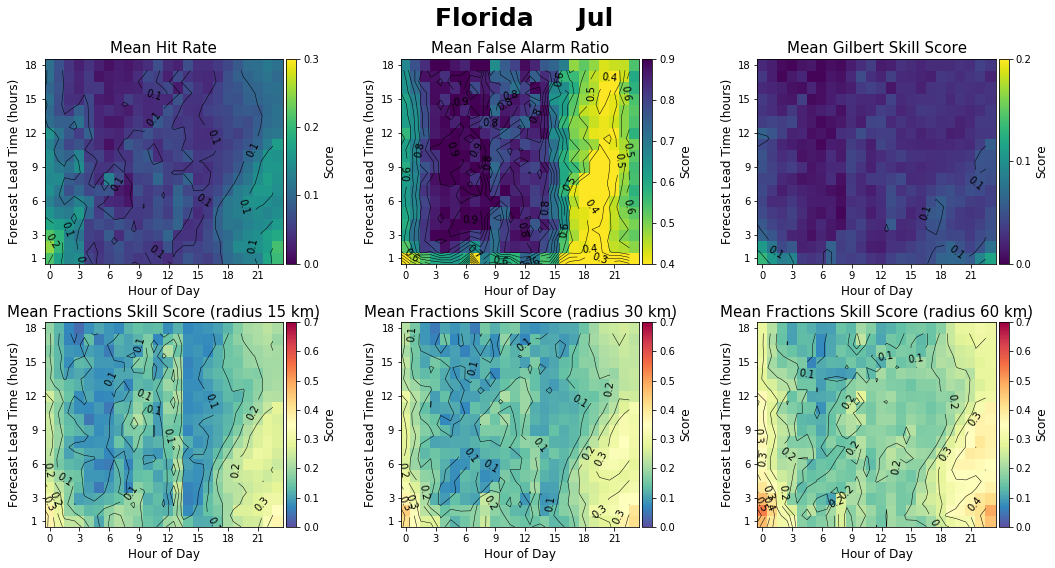

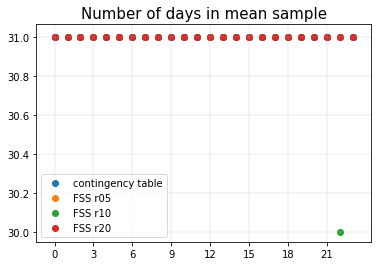

In [14]:
DOMAIN = 'Florida'
MONTH = 7

CT = get_HRRR_GLM_stats_hov_by_month(DOMAIN, MONTH)
FSS = get_HRRR_GLM_FSS_hov_by_month(DOMAIN, MONTH, radii=[5, 10, 20, 40])

#        [ax, data, vmax, vmin, cmap, name]
plots = [[0, CT['Hit Rate'], 0.3, 0, 'viridis', 'Hit Rate'], 
         [1, CT['False Alarm Ratio'], .9, .4, 'viridis_r', 'False Alarm Ratio'], 
         [2, CT['Gilbert Skill Score'], .2, 0, 'viridis', 'Gilbert Skill Score'], 
         [3, FSS['r05'], .7, 0, 'Spectral_r', 'Fractions Skill Score (radius 15 km)'],
         [4, FSS['r10'], .7, 0, 'Spectral_r', 'Fractions Skill Score (radius 30 km)'],
         [5, FSS['r20'], .7, 0, 'Spectral_r', 'Fractions Skill Score (radius 60 km)'],]

fig, axes = plt.subplots(2,3, figsize=[15,8])
axes = axes.flatten()

for p in plots:
    ax, data, vmax, vmin, cmap, name = p
    plt.sca(axes[ax])
    plt.pcolormesh(range(25), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
    plt.colorbar(label='Score', pad=.01, ticks=np.arange(vmin, vmax+.01, .1))
        
    CS = plt.contour(range(24), range(1,19), data, colors='k', linewidths=.5, levels=np.arange(vmin-.1,vmax+1,.05))
    plt.clabel(CS, fmt='%1.1f')

    plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
    plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )

    plt.ylabel('Forecast Lead Time (hours)')
    plt.xlabel('Hour of Day')
    plt.title('Mean %s' % name)
    
plt.suptitle('%s     %s' % (DOMAIN, datetime(2018, MONTH, 1).strftime('%b')), fontsize=25)
    
fig.tight_layout()

plt.subplots_adjust(top=.89)


# Check Sample Count
plt.figure()
plt.scatter(range(24), CT['samples'], label='contingency table')
plt.scatter(range(24), FSS['samples r05'], label='FSS r05')
plt.scatter(range(24), FSS['samples r10'], label='FSS r10')
plt.scatter(range(24), FSS['samples r20'], label='FSS r20')
plt.xticks(range(0,24,3))
plt.grid()
plt.legend()
plt.title('Number of days in mean sample');

---
# Hovemollers Departure from HRRR
Compare a domains again the HRRR-wide statistics

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:152: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:125: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:226: RuntimeWarning: invalid value encountered in true_divide
  GSS = (a-a_r)/(a+b+c-a_r)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:196: RuntimeWarning: invalid value encountered in true_divide
  CSI = a/(a+b+c)


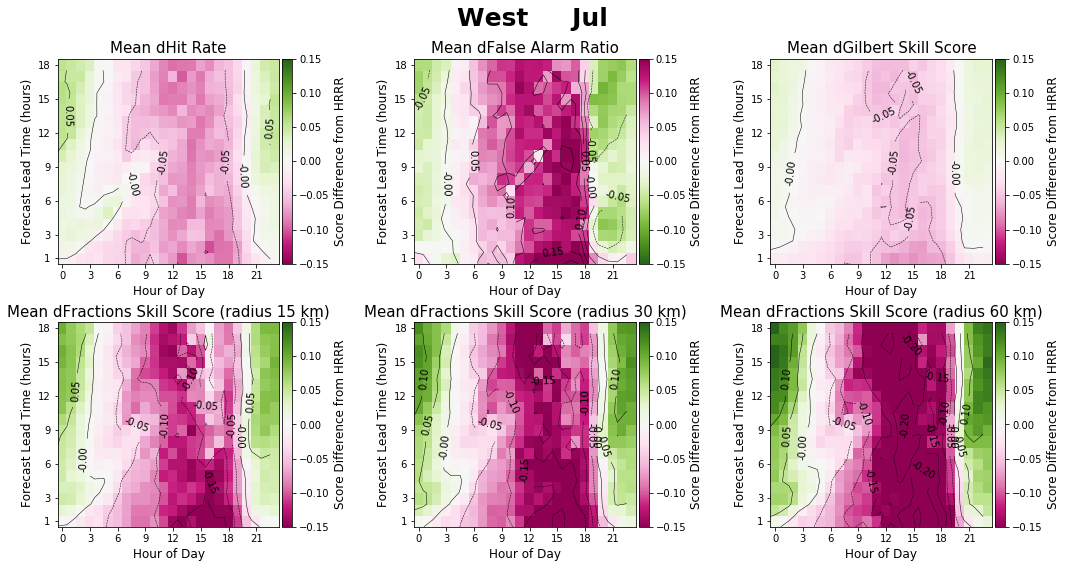

In [16]:
DOMAIN = 'West'
MONTH = 7

reference_DOMAIN = 'HRRR'

CT = get_HRRR_GLM_stats_hov_by_month(DOMAIN, MONTH)
FSS = get_HRRR_GLM_FSS_hov_by_month(DOMAIN, MONTH, radii=[5, 10, 20])

CT_HRRR = get_HRRR_GLM_stats_hov_by_month(reference_DOMAIN, MONTH)
FSS_HRRR = get_HRRR_GLM_FSS_hov_by_month(reference_DOMAIN, MONTH, radii=[5, 10, 20])



#       [Ax, data, vmax, vmin, cmap, name]
plots = [[0, CT['Hit Rate']-CT_HRRR['Hit Rate'], .15, -.15, 'PiYG', 'dHit Rate'], 
         [1, CT['False Alarm Ratio']-CT_HRRR['False Alarm Ratio'], .15, -.15, 'PiYG_r', 'dFalse Alarm Ratio'], 
         [2, CT['Gilbert Skill Score']-CT_HRRR['Gilbert Skill Score'], .15, -.15, 'PiYG', 'dGilbert Skill Score'], 
         [3, FSS['r05']-FSS_HRRR['r05'], .15, -.15, 'PiYG', 'dFractions Skill Score (radius 15 km)'],
         [4, FSS['r10']-FSS_HRRR['r10'], .15, -.15, 'PiYG', 'dFractions Skill Score (radius 30 km)'],
         [5, FSS['r20']-FSS_HRRR['r20'], .15, -.15, 'PiYG', 'dFractions Skill Score (radius 60 km)'],]

fig, axes = plt.subplots(2,3, figsize=[15,8])
axes = axes.flatten()

for p in plots:
    ax, data, vmax, vmin, cmap, name = p
    plt.sca(axes[ax])
    plt.pcolormesh(range(25), range(1,20), data, vmax=vmax, vmin=vmin, cmap=cmap)
    plt.colorbar(label='Score Difference from %s' % reference_DOMAIN, pad=.01)
        
    CS = plt.contour(range(24), range(1,19), data, colors='k', linewidths=.5, levels=np.arange(vmin-.15,vmax+1,.05))
    plt.clabel(CS, fmt='%1.2f')

    plt.yticks(np.array([1, 3, 6, 9, 12, 15, 18])+.5, [1, 3, 6, 9, 12, 15, 18])
    plt.xticks(np.arange(0,24,3)+.5, range(0,24,3), )

    plt.ylabel('Forecast Lead Time (hours)')
    plt.xlabel('Hour of Day')
    plt.title('Mean %s' % name)
    
plt.suptitle('%s     %s' % (DOMAIN, datetime(2018, MONTH, 1).strftime('%b')), fontsize=25)
    
fig.tight_layout()

plt.subplots_adjust(top=.89)

In [24]:
m = draw_HRRR_map()

In [37]:
H = get_hrrr_variable(datetime(2017, 8, 25,23), 'PRATE:surface', fxx=1)


 >> Dowloading tempfile: ./temp_hrrr_2017082523_f01_PRA.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20170825/hrrr.t23z.wrfsfcf01.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20170825/hrrr.t23z.wrfsfcf01.grib2.idx
 >> Matched a variable:  63:47876860:d=2017082523:PRATE:surface:1 hour fcst
 >> Byte Range: 47876860 47987110
  Run Date: 2017-08-25 23:00 UTC F01
Valid Date: 2017-08-26 00:00 UTC


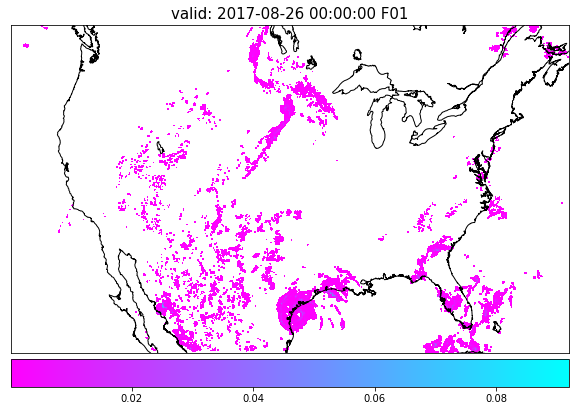

In [38]:
plt.figure(figsize=(10,10))
plot_this = np.ma.array(H['value'], mask=H['value']==0)
m.pcolormesh(H['lon'], H['lat'], plot_this, latlon=True, cmap='cool_r')
plt.colorbar(orientation='horizontal', pad=.01)
plt.title('valid: %s F%02d' % (H['valid'], H['fxx']))
m.drawcoastlines()

In [27]:
H['value'].min()

0.0